In [1]:
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
import math
from lib.Recording import Recording
from lib.KalmanFilter import KalmanFilter

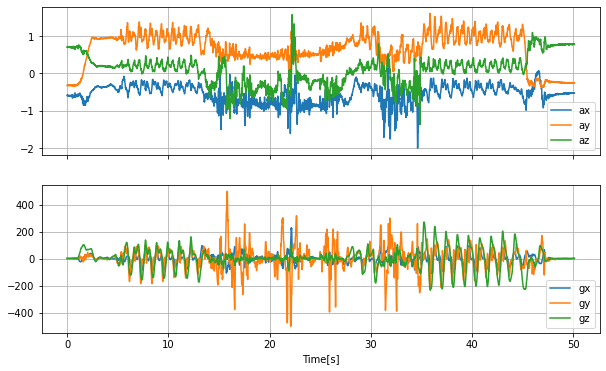

In [34]:
filename = '../recordings/reference/released_4.json'
trace = Recording(filename, no_labels = True, mute = True)
trace.plot([['ax', 'ay', 'az'], ['gx', 'gy', 'gz']])
# note: sampled every 80ms => frequency of 1/0.08 = 12.5Hz

In [35]:
ax_list = list(zip(trace.data["ax"].timestamps, trace.data["ax"].values))
ay_list = list(zip(trace.data["ay"].timestamps, trace.data["ay"].values))
az_list = list(zip(trace.data["az"].timestamps, trace.data["az"].values))

In [36]:
#signal.find_peaks(trace.data["ay"].values)
x_axis = np.array(trace.data["ax"].timestamps)
magnitude_x = np.array(trace.data["ax"].values)
magnitude_y = np.array(trace.data["ay"].values)
magnitude_z = np.array(trace.data["az"].values)
magnitude = np.sqrt(magnitude_x**2 + magnitude_y**2 + magnitude_z**2)
print(magnitude)
print(math.sqrt(trace.data["ax"].values[0]**2 + trace.data["ay"].values[0]**2 + trace.data["az"].values[0]**2))
avg_magnitude = np.mean(magnitude)
net_magnitude = magnitude - avg_magnitude
print(net_magnitude)

[0.97393549 0.9748527  0.97476902 ... 0.97412273 0.97772578 0.97942674]
0.9739354860254535
[-0.08274244 -0.08182523 -0.08190891 ... -0.08255519 -0.07895215
 -0.07725119]


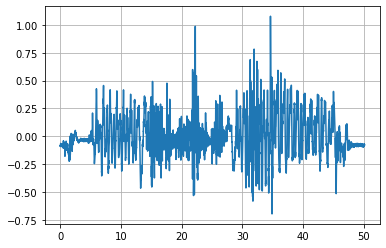

In [37]:
fig, ax = plt.subplots()
#ax.plot(x_axis[0:int(len(x_axis)/5)], net_magnitude[0:int(len(x_axis)/5)])
ax.plot(x_axis, net_magnitude)
ax.grid()
plt.show()

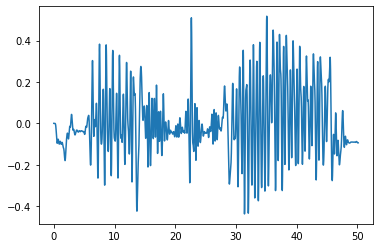

In [38]:
# PHASE 1: low pass filter. I have no idea why these parameters work
b, a = signal.butter(12, 4, fs=250)
y = signal.lfilter(b, a, net_magnitude)
#plt.plot(x_axis[int(len(x_axis)/3)*1: int(len(x_axis)/3)*2], y[int(len(x_axis)/3)*1: int(len(x_axis)/3)*2])
plt.plot(x_axis, y)
plt.show()

In [42]:
# PHASE 2: iterate over everything, find peaks and valleys and combine into steps
if len(x_axis < 4):
    exit(1)
MAX_STEP_LENGTH = 1.6
halfstep = None # (int: x1, int: x2, bool: upwards) if upwards: valley then peak, otherwise opposite
curr_walk = [] # list of steps. step: (int: x1, int: x2, int: x3, bool: VPV) VPV=> valley peak valley, otherwise PVP
recent_valley_indexes = []
recent_peak_indexes = []
walk_list = []
for i in range(1, len(x_axis)-2):

    height = y[i]
    type = 2 # 0 for peak, 1 for valley, 2 for neither
    if y[i-1] < height and y[i+1] < height:
        type = 0
    elif y[i-1] > height and y[i+1] > height:
        type = 1
    if type == 2:
         continue
    timestamp = x_axis[i]
    if len(recent_valley_indexes) > 0:
        oldest_acceptable_valley_index = -1
        for index_index, index in enumerate(recent_valley_indexes):
            if timestamp-x_axis[index] < MAX_STEP_LENGTH:
                oldest_acceptable_valley_index = index_index
                break
        if oldest_acceptable_valley_index >= 0:
            recent_valley_indexes = recent_valley_indexes[oldest_acceptable_valley_index:]
        else:
            recent_valley_indexes = []

    if len(recent_peak_indexes) > 0:
        oldest_acceptable_peak_index = -1
        for index_index, index in enumerate(recent_peak_indexes):
            if timestamp-x_axis[index] < MAX_STEP_LENGTH:
                oldest_acceptable_peak_index = index_index
                break
        if oldest_acceptable_peak_index >= 0:
            recent_peak_indexes = recent_peak_indexes[oldest_acceptable_peak_index:]
        else:
            recent_peak_indexes = []

    if halfstep != None and timestamp-x_axis[halfstep[0]] > MAX_STEP_LENGTH:
        halfstep = None
    if len(curr_walk) > 0 and timestamp-x_axis[curr_walk[-1][0]] > MAX_STEP_LENGTH:
        walk_list.append(curr_walk)
        curr_walk = []

    if type == 0:
        recent_peak_indexes.append(i)
        if len(recent_valley_indexes) > 0:
            last_halfstep_index = 0 if halfstep == None else halfstep[0]
            for j in range(len(recent_valley_indexes)-1, 0, -1):
                if recent_valley_indexes[j] < last_halfstep_index:
                    break
                if len(curr_walk) > 0 and recent_valley_indexes[j] < curr_walk[-1][1]:
                    break
                if height - y[recent_valley_indexes[j]] > 0.08: #might have found a half step
                    if halfstep != None: #does it continue a previous halfstep?
                        if not halfstep[2]: #if it went downwards
                            if i - halfstep[1] < 4*(i-recent_valley_indexes[j]): 
                                # the distance from halfstep valley to new peak should not be disproportionately large compared to the distance between valley and peak (also, halfstep valley and valley might be the same)
                                step = (halfstep[0], halfstep[1], i, False)
                                if curr_walk == None:
                                    curr_walk = []
                                curr_walk.append(step)
                                halfstep = None
                        else: # if it went upwards, but might be longer than expected?
                            if i - halfstep[0] < 4*(i-recent_valley_indexes[j]): 
                                halfstep = (halfstep[0], i, True)
                    elif len(curr_walk) > 0: # does it continue a previous step?
                        step = curr_walk[-1]
                        if step[3]: # if the step ended with a valley
                            if i - step[2] < 4*(i-recent_valley_indexes[j]): 
                                halfstep = (step[2], i, True)
                        else: # if it ended with a peak, but might be longer than expected?
                            if i - step[1] < 3*(i-recent_valley_indexes[j]) and i - step[1] < 4*(step[2]-step[1]): 
                                step = (step[0], step[1], i, False)
                                curr_walk[-1] = step
                    else:
                        halfstep = (recent_valley_indexes[j], i, True)
    else:
        recent_valley_indexes.append(i)
        if len(recent_peak_indexes) > 0:
            last_halfstep_index = 0 if halfstep == None else halfstep[0]
            for j in range(len(recent_peak_indexes)-1, 0, -1):
                if recent_peak_indexes[j] < last_halfstep_index:
                    break
                if len(curr_walk) > 0 and recent_peak_indexes[j] < curr_walk[-1][1]:
                    break
                if y[recent_peak_indexes[j]] - height > 0.08: #might have found a half step
                    if halfstep != None: #does it continue a previous halfstep?
                        if halfstep[2]: #if it went upwards
                            if i - halfstep[1] < 4*(i-recent_peak_indexes[j]): 
                                # the distance from halfstep peak to new valley should not be disproportionately large compared to the distance between peak and valley (also, halfstep peak and peak might be the same)
                                step = (halfstep[0], halfstep[1], i, True)
                                if curr_walk == None:
                                    curr_walk = []
                                curr_walk.append(step)
                                halfstep = None
                        else: # if it went downwards, but might be longer than expected?
                            if i - halfstep[0] < 4*(i-recent_peak_indexes[j]): 
                                halfstep = (halfstep[0], i, False)
                    elif len(curr_walk) > 0: # does it continue a previous step?
                        step = curr_walk[-1]
                        if not step[3]: # if the step ended with a peak
                            if i - step[2] < 4*(i-recent_peak_indexes[j]): 
                                halfstep = (step[2], i, False)
                        else: # if it ended with a valley, but might be longer than expected?
                            if i - step[1] < 3*(i-recent_peak_indexes[j]) and i - step[1] < 4*(step[2]-step[1]): 
                                step = (step[0], step[1], i, True)
                                curr_walk[-1] = step
                    else:
                        halfstep = (recent_peak_indexes[j], i, False)
walk_list.append(curr_walk)
sum = 0
print(len(walk_list)-1)
for walk in walk_list:
    if len(walk) > 3:
        sum += len(walk)
print(sum)



9
60
